# Guide to Thresholding, Subtraction, Averaging, and the DRAM interface in CustomLogic 

[CustomLogic User guide](https://documentation.euresys.com/Products/COAXLINK/COAXLINK_16_0/en-us/Content/11_Pdf/D209ET-Coaxlink_CustomLogic_User_Guide-eGrabber-16.0.2.2128.pdf)

Written by: Ryan Forelli

Last Modified: 1/25/2023

Revisions:
- 1/23: changed all examples to a resolution of 256x320, added DRAM averaging example
- 1/25: added subtraction-averaging DRAM example

## 1. Introduction

The CustomLogic toolkit features a Vivado reference design allowing users to implement custom image processing and manipulation on the onboard XCKU035 FPGA. The 3602 Coaxlink Octo and 3603 Coaxlink Quad CXP-12 are supported through CustomLogic. This repository provides reference designs for the 3602 Coaxlink Octo. The CustomLogic package and this reference design have the following software/hardware requirements. A few presets in eGrabber studio are also required.

### 1.a. Software Requirements
- Vivado 2018.3
- eGrabber 22.1 or higher (although any version in the past few years should work)

### 1.b. Hardware Requirements
- **Single** 3602 Coaxlink **Octo** (we can switch to two if these examples work)
- Phantom S710 camera

### 1.c. eGrabber Studio Presets
- Set pixel format to Mono 12-bit
- Set unpacking mode (under "Data Stream" menu) to "Lsb"
- Set Banks to BankA
- Set camera resolution to 256x320

---------------------------

## 2. Intro to High-level Synthesis

The designs included in this repository rely heavily on high-level synthesis (HLS). Essentially, HLS is C++ for FPGAs which greatly streamlines the implementation of more complex algorithms. The downside is we cannot optimize our designs to the same degree we could with a hardware description language (HDL). The C++ code we write and strategically placed pragmas goes through a C-synthesis process which translates our design to less-than human readable register-transfer level (RTL) description. Some resources to get started with HLS is included below. While many functions/constructs valid in standard C++ compilers are valid in HLS, many are not (e.g. malloc, printf, etc). However, the behavior of HLS can be "simulated" by running it through g++ like normal, in which case these functions can be used. It is important to remember we are writing hardware in HLS, not software. The processing architecture is not fixed on an FPGA. Many of the standard practices for optimizing a program for a CPU are non-existent or take different forms in HLS. These guides provide good explanations.

- https://docs.xilinx.com/v/u/en-US/ug998-vivado-intro-fpga-design-hls
- https://indico.cern.ch/event/857790/attachments/1929374/3199760/HLS_Tutorial.pdf

---------------------------

## 3. Repository Structure


The repository contains five reference designs (05 is omitted on purpose).
- **01_fw_sample_thresholding**: This design performs pixel thresholding. Currently any pixel below 2047 will be set to 0. Any pixel greater than or equal to 2047 will remain unchanged.
- **02_fw_sample_subtraction**: This design subtracts every other image. Given frames: f0, f1, f2, f3,..., f0 and f2 will be transferred to the host like normal, f1 will contain the subtraction result f1−f0 and f3 will contain f3−f2. Currently, saturation logic is enabled to prevent overflows. For example, 400 − 3010 = 0. All arithmetic is unsigned 12-bit.
- **03_fw_sample_average_9frames**: This design averages every 9 frames, storing the result in the 10th frame. For example, n9 = sum(n0, n1,... n8). The accumulator in this design is sized at 16 bits to cover the possible range of unsigned 12-bit additions of ten numbers.
- **03_fw_sample_average_499frames**: Same as above, except this design averages every 499 frames, storing the result in the 500th frame. For example, n499 = sum(n0, n1,... n498). The accumulator in this design is sized at **21** bits to cover the possible range of unsigned 12-bit additions of five-hundred numbers. This bitwidth MUST be increased if the length of the addition or pixel format changes.
- **04_fw_sample_average_9frames_DRAM**: Same as above, except this design averages every 9 frames by first storing them in DRAM, storing the result in the 10th frame.
- **06_fw_sample_subtraction_average_8groups_1000frames_DRAM**: Full subtraction-averaging utilizing DRAM. 8 groups of 500 frames each (post-subtraction), averaged and interleavd with the ninth group. 


---------------------------

## 4. Getting started

### 4.a. Thresholding

Let's start with **01_fw_sample_thresholding**. Looking at the project structure, we have 

- **01_readme**: CustomLogic readme
- **02_coaxlink**: Encrypted CoaXPress IP and other proprietary firmware. We will not touch this.
- **03_scripts**: Vivado project build scripts. We will be running scripts in here but no modification should be necessary.
- **04_ref_design**: CustomLogic top-level and sub-module HDL designs. Since we are using HLS, we shouldn't need to touch this.
- **05_model_design_hls**: Contains all HLS for this project. We will be working here.
- **06_release**: The final bitstream for the FPGA will appear in this folder. Note that I have included precompiled bitstreams for all projects.  

Looking at **05_model_design_hls**. We will see a few more folders. 
- srcs: Our HLS source C++ files.
- scripts: Contains our C-synthesis script. We should not have to touch this unless we want to disable C-simulation.
- tb_data: Contains testbench data for c-simulation.

Only a few of the HLS files are important to us at the moment. myproject_axi.cpp is the top-level file. We should never have to change anything in there unless we have to communicate with the DRAM interface. The important file is **myproject.cpp**. 

In **myproject.cpp**, scroll to the function myproject(). First we'll see the input data stream and output data stream provided by CustomLogic (see 04_ref_design/CustomLogic.vhd for top-level interfaces). These data streams transfer c structs typenamed ``video_if_t``. We can see what data is stored in these structs by looking in CustomLogic.h. 

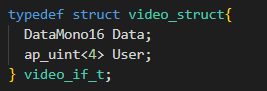

We can see we have image data stored in ``Data``. The type of the member is ``DataMono12`` which is really just a 128-bit wide integer. This is because the data stream depth on the Euresys Octo is 128 bits, meaning we get access to 128-bits of data every clock cycle. We are recording at 12-bit (which is packed into 2-bytes), so every cycle we get 128 / 16 = 8 pixels. This is extremely important to remember. Also note this file defines a macro ``MONO16PIX`` which allows us to "index" into this 128-bit wide string to retrieve individual pixels. The ``User`` field contains some side-channel info defined by Euresys. The four bits of this field tells use where in the image each packet comes from, although it is not relevant for our task.

Refocusing to ``myproject()``, we will see several function calls and a variable to define the packed depth of the data stream (which is just image_resolution / 8_pixels_per_data_packet). The first function, ``read_pixel_data()``, read's the raw data stream and forwards the relevant packets (packets with image data) to us by checking the side-channel User data. Next, we pass the image to ``pix_threshold()``, which is where the magic happens.
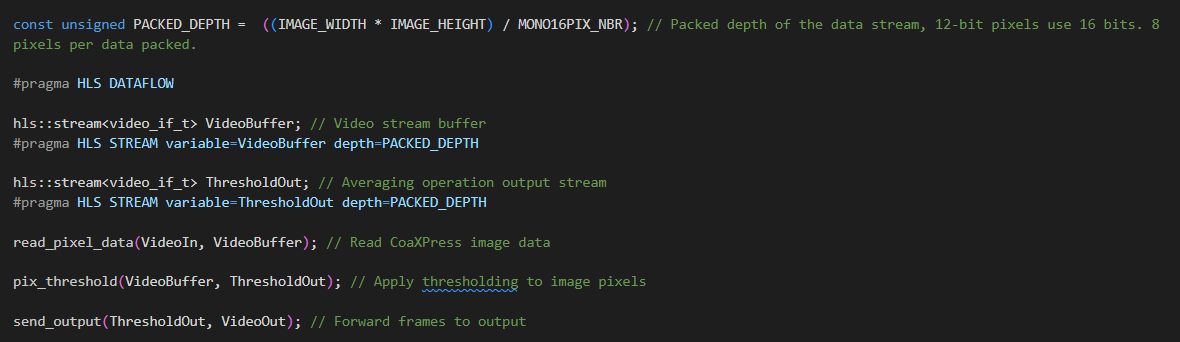


Looking at ``pix_threshold()``, we immediately begin looping through the image data, one packet at a time. After a packet is read from the functions input stream ``StreamIn``, we loop through the captured packet's bit string using MONO16PIX. For each pixel, we check if the pixel's value is greater than 2047. If so, we leave it alone, otherwise, we set the pixel to 0. Next we just attach the side-channel User info to the data packet, and write to the output stream.
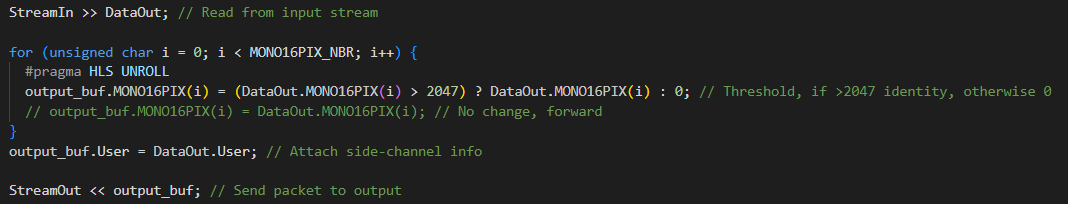

This example is fairly simple, and we could have placed this ternary statement in read_pixel_data, but as we increase the complexity of our algorithm, we would likely run into difficulties with scheduling and maintaining pipeline constraints during synthesis. Pipelining at the functional level (within ``myproject()``) and spreading the constituent components of the algorithm across multiple functions when using a streaming architecture typically yields the highest throughput. None of these examples are complex enough to warrant more than one function, but we can see the benefit when implementing neural networks, for example (see [hls4ml](https://fastmachinelearning.org/hls4ml/)).

## 4.b. Synthesis & Implementation

Before moving to the more complex examples, deploy and verify this example to ensure there are no higher-level issues. 

To execute C-simulation and C-synthesis, run ``vivado_hls 05_model_design_hls/scripts/run_hls.tcl``. Remember to use Vivado (HLS) 2018.3!

Looking at ``vivado_hls.log``, we will see the C-simulation run first. It is a lengthy file due to the size of the images. If we ctrl+F "Received Image", we will see the image that will be returned to the host. The image supplied to the testbench (found in ``tb_data/tb_input_features.dat``) writes an image consisting of a repeating arithmetic sequence, 0,1,2,3...4095,0,1,2,3...4095... If our thresholding code works, we should see a sequence 0,0,0,0,...2048,2049,...4095,0,0,0,0,...2048,2049,...4095... As expected, this is the image we receive.

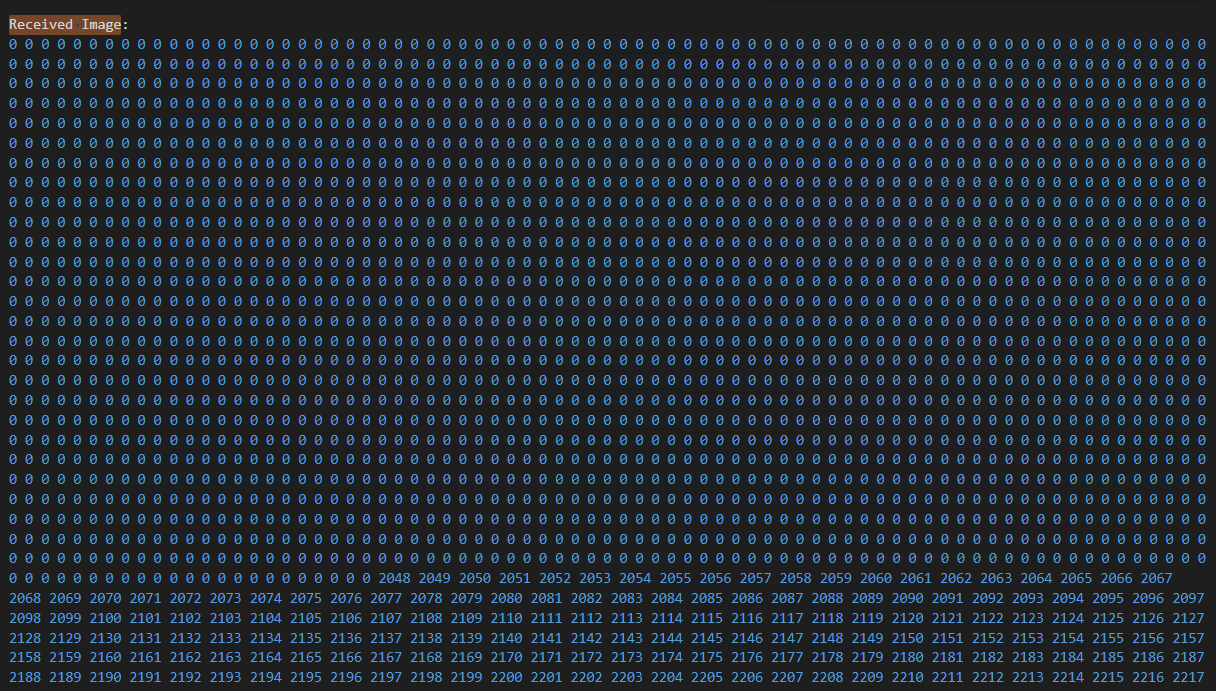


Once C-synthesis is complete, we can run logic synthesis and place & route. These processes compile a gate-level netlist of the required resources to implement the design and maps the design to the targeted FPGA. The script we will run also generates the bitstream. It takes a few hours, so ``nohup`` may be useful when executing this command, ``nohup vivado -mode tcl -source 03_scripts/run_impl.tcl &``. 


Once the process completes, the first thing we will want to check is the folder ``06_release``. If a .bit file appeared/updated, that means the process was successful. If not, check ``nohup.out`` for the error message. Once you've verified the bitstream was generated, let's check the timing report, ``post_route_phys_opt_timing_summary.rpt``. The timing reports tells us whether the synthesis tools were able to implement our design under the desired timing constraints. The frame grabber uses a 250MHz clock (4ns period), so achieving timing closure can be tricky. Even with simple designs, poorly written HLS or HDL can result in timing failure. In ``post_route_phys_opt_timing_summary.rpt``, scroll down to the "Design Timing Summary". If the "WNS(ns)" or "TNS(ns)" value is negative, then timing failed. Here, we can see our worst negative slack (WNS) is 0.051ns, indicating timing closure.

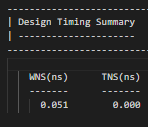


## 4.c. Deployment

Now we can deploy the bitstream (which should be named ``CoaxlinkOcto_1cam.bit``) to the frame grabber. Follow these steps for deployment.
1. Open **Euresys Coaxlink Firmware Manager** on host PC.
2. Drag and drop the bitstream to the upload box in **Euresys Coaxlink Firmware Manager**.
3. In **Euresys Coaxlink Firmware Manager**, navigate to the **Coaxlink Cards** page via the sidebar menu icon.
4. Select the Octo frame grabber.
5. Select **Install firmware variant...**.
6. Select **proceed** and **Ok**.
7. One completed, restart host PC.


Now we can capture a buffer in eGrabber studio. Reminder: set the presets listed at the start of the guide before continuing. It is recommended to run the frame grabber at a low frame rate (~50fps) while testing to verify the algorithm's behavior. Setting a ``BufferPartCount`` of a relatively high number is recommended at higher framerates to take advantage of batching and to reduce processing overhead. I also recommend capturing in raw or tiff format for these tests. When you capture a buffer, you should see the darker regions of the image saturated to completely dark. 

---------------------------


## 5. Subtraction Firmware Example

Once you verify the thresholding example works, we can move on to the image subtraction example project, ``02_fw_sample_subtraction``. The only substantial difference between the first example and this example is that ``pix_threshold()`` changes to ``pix_subtract()``. Just like last time, we loop through the image stream. This time, we have an arbitrator which just tells us whether we're buffering the current frame or subtracting a previously buffered frame from the current frame. Note that buffered frames (the subtrahends) are also transmitted back to host in this example. 

When the arbitrator is 0, we write all pixels in the current packet to the buffer ``buf``. 



When the next frame arrives (arbitrator=1), we subtract the buffered frame from the current frame, and forward the result to the output. Note that the operands are cast to unsigned fixed-point which supports overflow modes (e.g. AP_SAT, [more info here](https://docs.xilinx.com/r/en-US/ug1399-vitis-hls/Fixed-Point-Identifier-Summary?tocId=2KrIwwS1HQvpiafHrUBMHg)) as described earlier. 



The rest of this function is similar to ``pix_threshold()``. In testing this bitstream, even frames should be unchanged, and I would guess odd frames 
 (the subtraction result) will appear completely dark if the camera field of view is static.

 Note that this design failed timing. Achieving timing closure can be a weeks long task experimenting with the HLS and synthesis strategies, so given the TNS here is extremely low, it likely won't effect the implementations behavior. For a final implementation, we will want to ensure the design meets timing.

 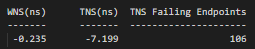


## 5.a. C-simulation

The c-simulation for this project supplies four images. The first two are identical. Thus, the second image we receive should be constant 0.

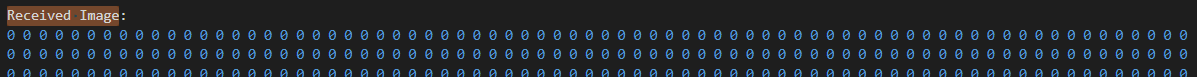

The third is the repeating arithmetic sequence 0,1,2,3...4095,0,1,2,3...4095.... The fourth is the repeating arithmetic sequence 4095,4094,4093...0,4095,4094,4093...0... Thus, we should se a sequence with a decrement of 2 until we reach constant 0 in the received fourth image. The subtraction results do not wrap around due to the saturation logic.

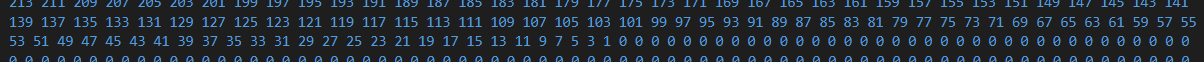

 ---------------------------

## 6. Averaging Firmware Example (9 frames)

Now let's move on to the image averaging example project, ``03_fw_sample_average_9frames``. This project averages every 9 frames, storing the average in the 10th frame. In this project, we will be looking at ``pix_average()``. Here, we have a frame counter and the same loop to read the data stream. The number of frames to average is ``num_frames``. For the first 9 frames, we simply add each pixel to a running sum "image" called ``sum``. Note that all of these frames are also sent to the output stream back to the host as well.




On the 10th frame, we calculate the average of the 9 frames, and forward the result back to the host in place of the 10th frame.



Follow the pixel thresholding example steps for synthesis & deployment. Remember to check timing results. If there are only a few failing endpoints in the timing report, it's likely the design will behave correctly. My implementation shows yields a likely-acceptable TNS. If these last two examples fail to behave properly, try the 499 frame example since it achieved timing closure.

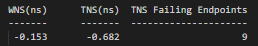

In testing this example, I would expect every 10th image to appear fairly similar to the preceding 9 assuming a static camera view.

IMPORTANT NOTE: Each pixel of running sum, "image" is sized at 16 bits. This is sufficient to cover the full range of the addition of ten 12-bit unsigned integers. If ``num_frames`` changes, this bit width MUST be sized appropriately. ceil(log2(num_frames*((2^12)-1))) should yield the desired bit width.


### 6.a. C-simulation

This c-simulation for this project supplies 9 images. The first five are all 0, the last four are constant 4000. Thus, the averaged image should be constant 1777.

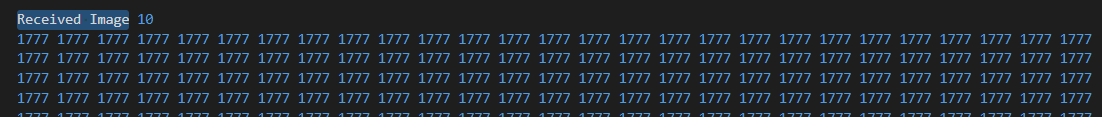

---------------------------

## 7. Averaging Firmware Example (499 frames)

Before moving on, lets generate some testbench data for this next example design. It is not already included due to GitHub file size limits.

In [ ]:
num_sets = 250
values_per_set = 83200

values_0 = [0] * values_per_set
values_4000 = [4000] * values_per_set

all_sets = [values_0] * num_sets + [values_4000] * num_sets

with open("03_fw_sample_average_499frames/05_model_design_hls/tb_data/tb_input_features.dat", "w") as file:
    for set_values in all_sets:
        line = " ".join(map(str, set_values))
        file.write(line + "\n")

Now let's move to averaging every 499 frames, ``03_fw_sample_average_499frames``. This project averages every 499 frames, storing the average in the 500th frame. We will still be looking at ``pix_average()``. Again, we have a frame counter and the same loop to read the data stream. The number of frames to average is ``num_frames``. For the first 499 frames, we simply add each pixel to a running sum "image" called ``sum``. Note that all of these frames are also sent to the output stream back to the host as well.




On the 500th frame, we calculate the average of the 499 frames, and forward the result back to the host in place of the 500th frame.



IMPORTANT NOTE: Each pixel of running sum, "image" is sized at 21 bits. This is sufficient to cover the full range of the addition of five-hundred 12-bit unsigned integers. If ``num_frames`` changes, this bit width MUST be sized appropriately. ceil(log2(num_frames*((2^12)-1))) should yield the desired bit width.

Looking at the timing report, we can see this example achieved timing closure. You may notice that even though this example and the previous example are nearly identical, one met timing while the other did not. These are instances where taking advantage of and experimenting with the various synthesis directives and strategies available in the Vivado Design Suite comes in handy. See [here](https://docs.xilinx.com/r/en-US/ug904-vivado-implementation/Using-Directives?tocId=dV9wYjuIP6n9oUJhkoHuRg) for more info. See ``03_scripts/run_impl.tcl`` to see the strategy, directives, and physical optimization loop we use for these designs.

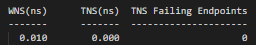



#### 7.a. C-simulation

This c-simulation for this project supplies 499 images. The first two hundred fifty are all 0, the last two hundred forty-nine are constant 4000. Thus, the averaged image should be constant 1995.

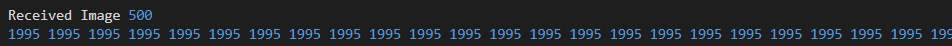

#### 7.b. Averaging Validation

To validate the averaging examples, import the raw image buffer in python, calculate the average of the first 9 or 499 images, and compare with the 10th or 500th. Use integer arithmetic.

---------------------------

## 8. DRAM Averaging Firmware Example (9 frames)


The CoaxLink Octo partitions 1GB of the onboard memory to CustomLogic. The DRAM can be accessed via the AXI4 memory-mapped protocol. Similar to section 6, in ``04_fw_sample_average_9frames_DRAM``, we will be averaging every 9 frames, and returning the average in the 10th frame. 

With relative ease, we can utilize this interface via HLS with only base address of the DRAM. We can treat this as a standard C pointer, ``onboard_mem_base``. The width of the data channel is ``STREAM_DATA_WIDTH`` (128 for the Octo), so we will be sending 128-bit strings to DRAM at a time. Note that the ``ap_uint<N>`` type is an N bit integer. The actual signals which comprise the AXI4 protocol have already been added to our IP's wrapper and integrated with the CustomLogic top-level function in ``CustomLogic.vhd`` and ``myproject_axi_wrp.vhd`` so no modifications should be required at the HDL level. HLS generates a port to input an offset address to the CustomLogic partition so we will not have to worry about partition offsets at the HLS level.

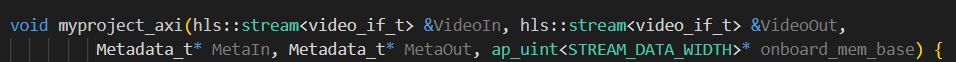

Now let's look at ``pix_average()``. The only change to the parameters of this function is the addition of the DRAM base address. We will be using array indexing instead of pointer arithmetic or ``memcpy()`` to simplify things. Thus, we now have a counter ``dram_wr_idx`` to keep track of where in DRAM we're writing. The storage of one 128-bit packet is simple. 



The rest of the function looks fairly similar to before, except now we wait until we save all 9 images before calculating the sum. I am hoping to avoid this in a later version so as to avoid incurring the latency cost.

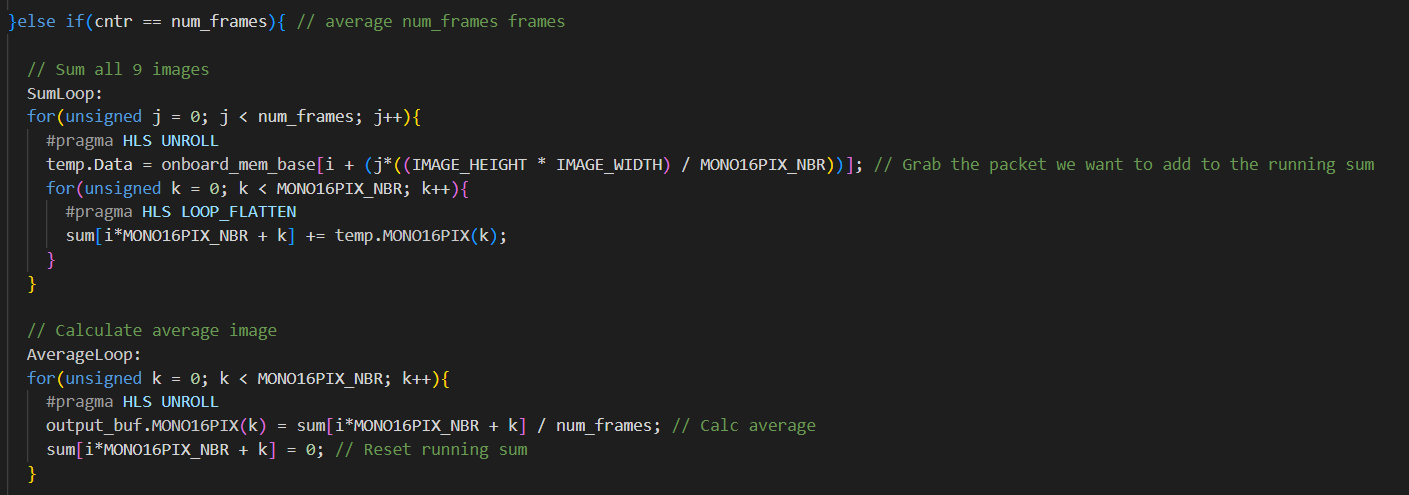


#### 8.a C-simulation


This c-simulation for this project is the same as section 6, but now we also supply a block of memory (enough for 12 frames rather than 1GB). Remember to increase the size of this buffer if you want to average >12 frames and run csim.

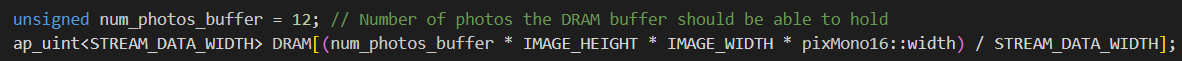

Again, this c-simulation supplies 9 images. The first five are all 0, the last four are constant 4000. As expected, the c-simulation returns an image with a constant 1777 value at the output.

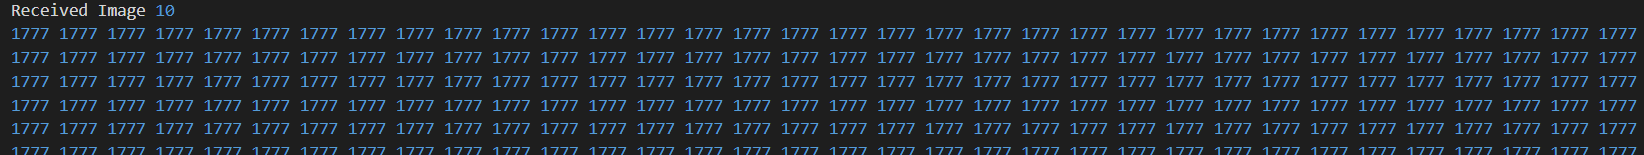

#### 8.b. DRAM Averaging Validation

This example was tested and verified on an Octo with an S710. We captured 50 frames in raw format (stored in ``08_hardware_results``) using the parameters listed at the beginning of this notebook. I couldn't move the camera from its microsope so it's a dark image, but we can see that each frame is at least slightly different from one another. So we will calculate the average of one batch of nine samples and compare with the 10th. It is difficult to determine which of the frames are the averaged by visual inspection so adding a constant (e.g. 500) may be advisable.

In [16]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
num_frames = 9 # Number of frames averaged
# ^^^ These should match CustomLogic

folder_path = '04_fw_sample_average_9frames_DRAM/08_hardware_results'

import os
import numpy as np
files_in_folder = os.listdir(folder_path)
num_images = sum(1 for file in files_in_folder if file.endswith('.raw'))
images = np.zeros((num_images, IMAGE_WIDTH, IMAGE_HEIGHT), dtype=np.uint16)
for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith('.raw'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'rb') as file:
            # Read file as 16-bit
            image_data = np.fromfile(file, dtype=np.uint16, count=IMAGE_WIDTH*IMAGE_HEIGHT)
            images[i, :, :] = image_data.reshape((IMAGE_WIDTH, IMAGE_HEIGHT))

In [17]:
images.shape

(50, 128, 128)

In [18]:
images[0] - images[1] # Clearly some variability in the acquired frames

array([[    0, 65534, 65531, ...,     0, 65531,     0],
       [    8,     0,     7, ..., 65532, 65529, 65526],
       [    3,     0,     5, ...,     7,     0,    19],
       ...,
       [65531, 65532,     7, ..., 65531,     0,     7],
       [    0, 65533,     9, ...,     7,     3, 65525],
       [    0,    12, 65534, ...,     2,    10, 65529]], dtype=uint16)

In [19]:
first_9_images = images[8:17] # Frames 8-17 were averaged
average_image = np.sum(first_9_images, axis=0) // num_frames

np.array_equal(average_image, images[17]) # Check if hardware average matches software

True

We can see the averaged frame matches our software calculation.

---------------------------

## 9. DRAM Subtraction-Averaging Firmware Example (8 "groups," 1000 frames)


This example implements the final algorithm. Every frame is subtracted from the next. 8 "groups" of these 500 subtracted frames are stored to DRAM before being averaged. The averaged result is 500 frames which are interleved with the 9th "group" that is sent back to host so that no relavent information is overwritten and that we can validate the hardwhere here.

Looking once again at ``pix_average()``, this example adds much of the subtraction and arbitration logic from ``02_fw_sample_subtraction``. Unfortunately, C-sim will likely fail due to the amount of memory required, but you can set ``num_groups = 3`` and ``num_frames = 4`` to run C-sim and validate the C code. I have verified this firmware on the Octo so it will hopefully run on your system with the same parameters. Also note that timing closure was achieved with this design.

#### 9.a. Acquisition Instructions

For this firmware, allocate a buffer size of 10,000 (max) in egrabber. eGrabber does not always buffer starting at frame 0 so we have to make sure we capture all 8000 frames plus the 1000 "result" frames (in which the 500 average results frames are interleaved). So initiate acquisition until you see what looks like white noise (see below) and then pause acquisition. These are the result frames. There is white noise because the default behavior for subtraction using Vivado HLS AP types is wrap-around. In ``02_fw_sample_subtraction`` we talk about overflow modes like ``AP_SAT``, but for this example we leave it off because python will also wrap around.

Once you've paused acquisition, make sure the buffer size is 10000, and then begin recording again until it's full.

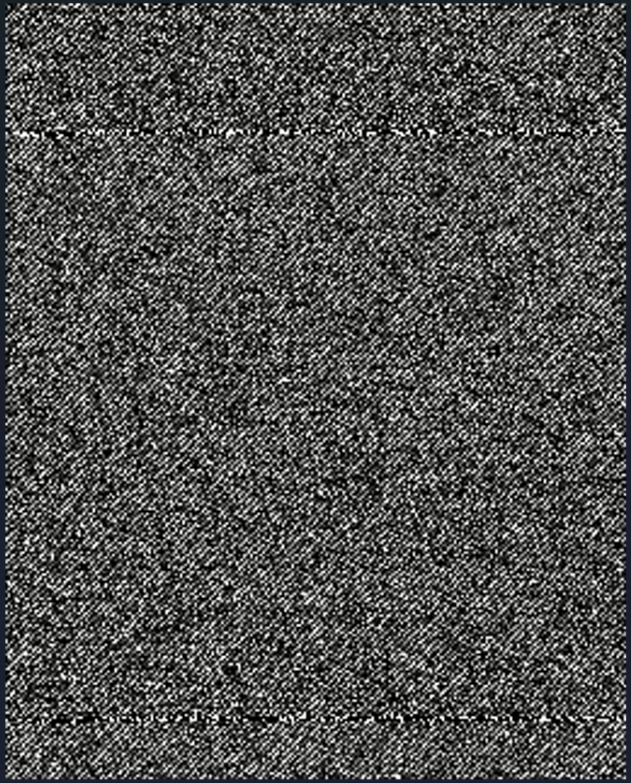

You can download the dataset acquired on our Octo below or record your own. I recommend saving your buffer in tiff format as well so you can see where the first "group"/experiment starts (after the white noise images at the beginning). This index will be ``start_idx``. Save your raw format frames to 08_hardware_results.

In [10]:
!curl 'https://drive.usercontent.google.com/download?id=1z8dp7GlcyfmMgDF3nawqpQKUBywdkaJo&export=download&confirm=t&uuid=8347dae7-d3cc-437a-b17a-09c69d68513e' --compressed > "06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/06_fw_sample_subtraction_average_8groups_1000frames_DRAM.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  925M  100  925M    0     0  93.0M      0  0:00:09  0:00:09 --:--:--  103M


In [11]:
!unzip 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/06_fw_sample_subtraction_average_8groups_1000frames_DRAM.zip -d 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results

Archive:  06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/06_fw_sample_subtraction_average_8groups_1000frames_DRAM.zip
  inflating: 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/image.0000.raw  
  inflating: 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/image.0001.raw  
  inflating: 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/image.0002.raw  
  inflating: 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/image.0003.raw  
  inflating: 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/image.0004.raw  
  inflating: 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/image.0005.raw  
  inflating: 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/image.0006.raw  
  inflating: 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/image.0007.ra

In [12]:
!rm 06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results/*.zip

In [13]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 320
num_groups = 8 # Number of groups averaged
num_frames = 1000 # Number of frames per group
# ^^^ These should match CustomLogic

folder_path = '06_fw_sample_subtraction_average_8groups_1000frames_DRAM/08_hardware_results'

import os
import numpy as np
files_in_folder = os.listdir(folder_path)
num_images = sum(1 for file in files_in_folder if file.endswith('.raw'))
images = np.zeros((num_images, IMAGE_WIDTH, IMAGE_HEIGHT), dtype=np.uint16)
for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith('.raw'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'rb') as file:
            # Read file as 16-bit
            image_data = np.fromfile(file, dtype=np.uint16, count=IMAGE_WIDTH*IMAGE_HEIGHT)
            images[i, :, :] = image_data.reshape((IMAGE_WIDTH, IMAGE_HEIGHT))

In [14]:
images.shape

(10000, 256, 320)

In [15]:
start_idx = 198 # looking at my data, the first frame of the first group/"experiment" is at index 198

images_subset = images[start_idx:start_idx+(num_groups*num_frames)+num_frames].reshape(num_groups+1, num_frames, images.shape[1], images.shape[2]) # grab our 9 "groups"
subtracted_images = images_subset[0:num_groups, 1::2, :, :] - images_subset[0:num_groups, ::2, :, :] # calculate subtractions from groups 1-8
average_images = np.sum(subtracted_images, axis=0) // num_groups # calculate average across groups 1-8
np.array_equal(average_images, images_subset[num_groups, 1::2, :, :]) # check that our hardware calculations match software by comparing with group 9's odd frames

True

Above, we can see the averaged frames from hardware match Python.

IMPORTANT NOTE: I believe some work will be required to optimize the HLS as the DRAM accesses creates a latency too high to reach 30 kfps. 

----------------------------

## 10. Conclusion

If you encounter any issues please let me know. I am always available over email, rff224@lehigh.edu.


#### A note about pragmas

Throughout the HLS source code you will find preprocessor directives called pragmas. In HLS, they allow us to control how our C structures are implemented in hardware. For example, we applied ``ARRAY_PARTITION`` pragmas to restructure how our arrays are partitioned among the FPGA's BRAMS. Partitioning large arrays can increase throughput (as a consequence of more read/write ports). For example, I observed a 16x latency decrease for the averaging function just by cyclically partitioning the running sum array. See [here](https://docs.xilinx.com/r/en-US/ug1399-vitis-hls/HLS-Pragmas) for a complete list of pragmas and more info. Note that some of the pragmas in this documentation are invalid in 2018.3 since the docs refer to Vitis 2023.

----------------------------